In [3]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.transforms as T 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import pandas as pd
import utils

TS = 48
MPATH = '__pycache__/dqn_policy_net.pt'
DO_TRAIN = False

# samples = list(range(201, 211)) #[201, 202, 203]
samples = [221, 243, 232, 202, 204, 214, 205, 239, 248, 273, 282, 289]
data_train, df_date = utils.load_data('AusGrid_preprocess.csv', samples, TS)

State : [PV.gen, LD, PV.charge, PV.dischare, BS, GD, COST]
- PV.gen : PV generatoin power
- LD : Load consumption power
- PV.charge : Battery charging power
- PV.dischare : Battery discharging power
- BS : Battery status
- GD : Grid imort(+)/export(-) power
- COST : Cost for power

Action : [0, 1]
- 0 : discharging
- 1 : charging

Cost funciton(Reward)
- Self consumption : (PV - PV.charge + PV.dischare - GD) / PV
- Self sufficency : (PV - PV.charge + PV.dischare - GD) / LD

In [5]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        HDS = 256
        self.layer1 = nn.Linear(n_observations, HDS)
        self.layer2 = nn.Linear(HDS, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [6]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
TARGET_UPDATE = 10

n_observaons = 7
print(n_observaons)
n_actions = 2
policy_net = DQN(n_observaons, n_actions).to(device)
target_net = DQN(n_observaons, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

7


<All keys matched successfully>

In [7]:
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


In [8]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

In [9]:

# optimizer = optim.RMSprop(policy_net.parameters())
optimizer = optim.AdamW(policy_net.parameters(), lr=1e-5, amsgrad=True)
memory = ReplayMemory(20000)

In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return 0

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
        
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)

    optimizer.step()

    return loss.item()

    

In [ ]:
def Action(x):
    if x.item() == 1:
        return "Charge"
    elif x.item() == 0:
        return "Discharge"
    else:
        return "None"

if DO_TRAIN == True:
    loss_list = []
    reward_list = []
    all_sc_ss = []

    loop = 10
    num_episodes = len(data_train)

    for l in range(loop):
        for i_episode in range(num_episodes):
            capacities = utils.cal_stds(data_train[i_episode%len(data_train)])
            for c in capacities:
                epMemory = list()
                env = utils.ENV_BATT(data_train[i_episode%len(data_train)], max(0, c))
                state = env.reset()
                state = state.clone().detach().unsqueeze(0)
                
                loss_value = 0.0
                reward_value = 0.0

                total_export = 0.0
                total_import = 0.0
                total_pv = 0.0
                total_ld = 0.0
                    
                for i in range(env.data_env.shape[0]):
                    action = select_action(state)        
                    observation, reward, done=env.step(action.item())
                    reward = torch.tensor([reward], device=device)
                    reward_value += reward.squeeze(0).numpy()

                    next_state = observation.clone().detach().unsqueeze(0)
                    memory.push(torch.as_tensor(state), action, next_state, reward)
                    state = next_state

                    loss_value += optimize_model()

                    total_export += state.squeeze(0).numpy()[5] if state.squeeze(0).numpy()[5] < 0 else 0
                    total_import += state.squeeze(0).numpy()[5] if state.squeeze(0).numpy()[5] > 0 else 0
                    total_pv += state.squeeze(0).numpy()[0]
                    total_ld += state.squeeze(0).numpy()[1]

                    if (i + 1) % TS == 0:
                        loss_list.append(loss_value)
                        loss_value = 0.0
                        reward_list.append(reward_value)
                        reward_value = 0.0


                sc = (total_pv + total_export)/total_pv
                ss = (total_ld - total_import)/total_ld
                all_sc_ss.append([sc, ss])
                print(i_episode, c, 'sc and ss', sc, ss)

        target_net.load_state_dict(policy_net.state_dict())
        torch.save(policy_net.state_dict(), MPATH)
        print(l, i_episode, 'Complete!!')

KeyboardInterrupt: 

In [ ]:
if DO_TRAIN == True:
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,5))
    axes[0].plot(np.array(reward_list), 'r')
    # plt.ylim(0, 0.4)
    axes[1].plot(np.array(loss_list), 'b')
    # plt.ylim(0, 0.4)
    plt.show() 

    plt.plot(np.array(all_sc_ss)[:, 0])
    plt.plot(np.array(all_sc_ss)[:, 1])
    plt.show()

In [18]:
data_test, df_date = utils.load_data('AusGrid_preprocess.csv', [93], TS)
data_test = data_test[0]
stds = utils.cal_stds(data_test)
print(stds)

(1, 4, 8, 15)


In [20]:
capacity = stds[3]
env = utils.ENV_BATT(data_test, max(0, capacity))
state = env.reset()
state = state.clone().detach().unsqueeze(0)

policy_net.load_state_dict(torch.load(MPATH, weights_only=True))
    
df_out = pd.DataFrame(columns=['PV', 'LD', 'PV.C', 'PV.D', 'BT', 'GD', 'COST', 'AC', 'RD'])

with torch.no_grad():
    for i in range(env.data_env.shape[0]):
        # action = select_action(state)
        action = policy_net(state).max(1).indices.view(1, 1)
        observation, reward, done=env.step(action.item())
        reward = torch.tensor([reward], device=device)
        next_state = observation.clone().detach().unsqueeze(0)
        st = next_state.numpy().squeeze(0)
        at = action.item()
        # print('Current x : ', t, 'Action :', at, ', y : ', next_state, 'reward :', reward.item())

        st = np.concatenate((st, np.array([at-1, reward.item()])))
        df_out.loc[i] = st
        state = next_state

KeyboardInterrupt: 

                      PV     LD     BT   AC     GD        RD
2012-07-01 00:30:00  0.0  0.131  1.500  0.0  0.131  0.000000
2012-07-01 01:00:00  0.0  0.131  1.500  0.0  0.131  0.000000
2012-07-01 01:30:00  0.0  0.131  1.500  0.0  0.131  0.000000
2012-07-01 02:00:00  0.0  0.131  1.500  0.0  0.131  0.000000
2012-07-01 02:30:00  0.0  0.144  1.500  0.0  0.144  0.000000
...                  ...    ...    ...  ...    ...       ...
2012-07-05 22:30:00  0.0  0.850  2.974  0.0  0.850  0.576084
2012-07-05 23:00:00  0.0  0.531  2.974  0.0  0.531  0.575372
2012-07-05 23:30:00  0.0  0.225  2.974  0.0  0.225  0.575372
2012-07-06 00:00:00  0.0  0.163  2.974  0.0  0.163  0.575275
2012-07-06 00:30:00  0.0  0.144  2.974  0.0  0.144  0.575252

[241 rows x 6 columns]


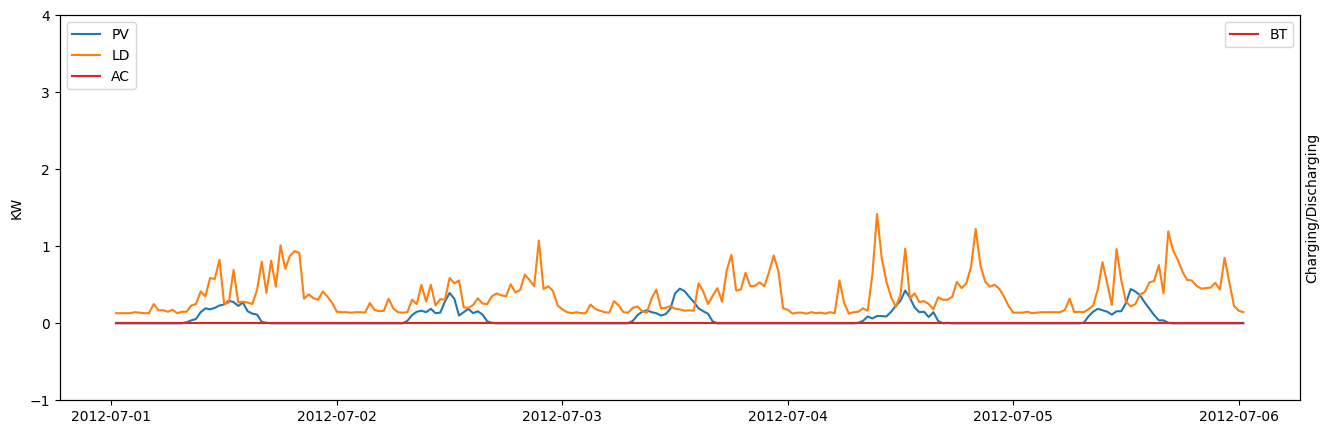

In [ ]:
start_pos = 0
duration = TS*5
df_dis = df_out[['PV', 'LD', 'BT', 'AC', 'GD', 'RD']]
df_dis = df_dis.set_index(pd.Index(df_date.values))

pv =  df_dis['PV'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ld =  df_dis['LD'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
bt =  df_dis['BT'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ac =  df_dis['AC'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values

fig, ax1 = plt.subplots(figsize=(16, 5))
ax1.plot(df_date.values[start_pos:start_pos+duration+1], pv, label='PV', color='#1f77b4')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ld, label='LD', color='#ff7f0e')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='AC', color='#d62728')
ax1.legend(loc='upper left')
ax1.set_ylabel('KW')
ax1.set_ylim(-1, 4)

ax2 = ax1.twinx()
ax2.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='BT', color='#d62728')
ax2.legend(loc='upper right')
ax2.set_ylabel('Charging/Discharging')
ax2.set_yticks([])
ax2.set_ylim(-1, 4)

# ax = df_dis[['PV', 'LD', 'BT', 'AC']].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].plot(figsize=(16,5))
# ax.set_ylim(-1, 3)
# ax.set_ylabel('KW')
print(df_dis.loc[df_date.values[start_pos]:df_date.values[start_pos+duration]])
plt.show()

Text(0, 0.5, 'KW')

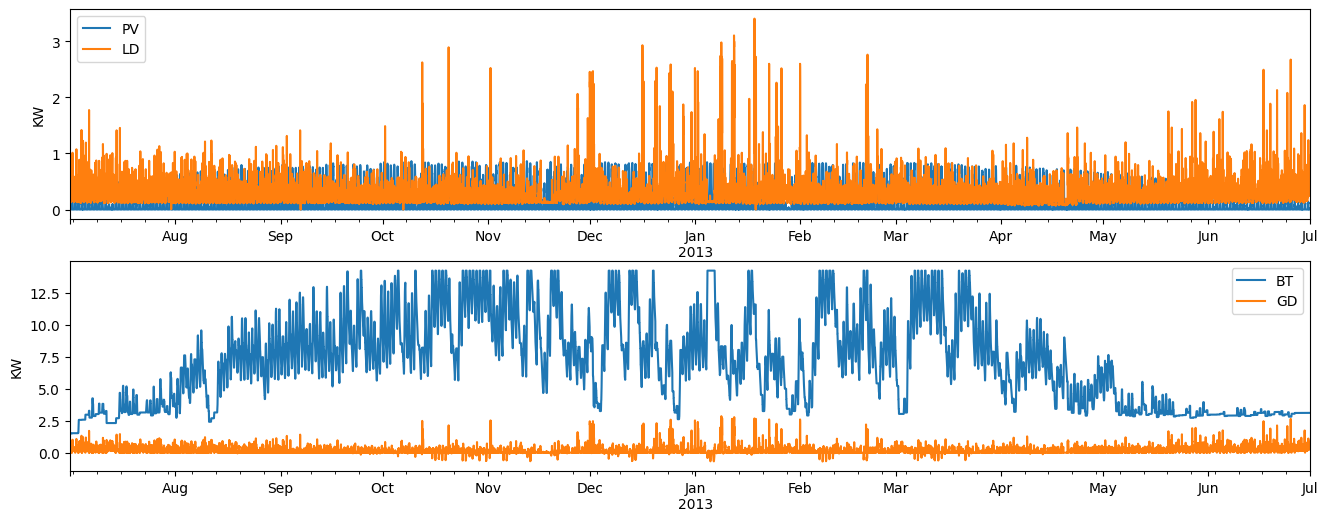

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
df_dis[['PV', 'LD']].plot(ax=axes[0])
df_dis[['BT', 'GD']].plot(ax=axes[1])

axes[0].set_ylabel('KW')
axes[1].set_ylabel('KW')

In [ ]:
Egen = df_out['PV'].sum()
print(Egen, 'KW')
Eload = df_out['LD'].sum()
print(Eload, 'KW')
GDimport = df_out[df_out['GD'] > 0]['GD'].sum()
print(GDimport)
GDexport = df_out[df_out['GD'] < 0]['GD'].sum()
print(GDexport)

SC = (Egen + GDexport)/Egen
SS = (Eload - GDimport)/Eload
print('SC :', SC)
print('SS :', SS)


2574.432000159286 KW
4791.973995695822 KW
2346.703999398276
-127.54700047615916
SC : 0.9504562558000105
SS : 0.5102844878736614


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
 
max_len = len(df_out)

pv =  df_out['PV'].iloc[:].values
ld =  df_out['LD'].iloc[:].values
bt =  df_out['BT'].iloc[:].values
ac =  df_out['AC'].iloc[:].values
# rd =  df_out['RD'].iloc[:].values
# ct =  df_out['COST'].iloc[:].values

def interactive_plot(window, start):    
    window *= 48
    start *= 48
    fig, ax1 = plt.subplots(figsize=(16, 5))    
    ax1.plot(df_date.values, pv, label='PV', color='#1f77b4')
    ax1.plot(df_date.values, ld, label='LD', color='#ff7f0e')
    ax1.plot(df_date.values, ac, label='AC', color='#d62728')
    # ax1.plot(df_date.values, rd, label='RD', color='black')
    # ax1.plot(df_date.values, ct, label='COST', color='grey')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('KW')

    ax2 = ax1.twinx()
    ax2.plot(df_date.values, bt, label='BT', color='#2ca02c')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('KW')
    
    start = min(start, max_len-window)
    ax1.set_xlim(df_date.values[start], df_date.values[start+window-1])
    
    plt.show()

 
 
interact(interactive_plot, window=(1, 10, 1), start=(0, 365, 1))

interactive(children=(IntSlider(value=5, description='window', max=10, min=1), IntSlider(value=182, descriptio…

<function __main__.interactive_plot(window, start)>